In [118]:
import os

import torch
import torchvision
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# data_dir = 'OpenImages'
# num_samples = 100
# classes = ["Car"]

In [3]:
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)

In [4]:
# print("Downloading is starting...")
# download_dataset(data_dir,
#                  classes,
#                  limit=num_samples)

In [5]:
# from PIL import Image

# img = Image.open("OpenImages/car/images/0000048549557964.jpg")
# plt.imshow(img); plt.show()

## Model Creation


In [6]:
pip install segmentation_models_pytorch

<!-- ### Downloading CamVid dataset -->

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

data_directory = './data/CamVid/'

# load repo with data if it does not exist
if not os.path.exists(data_directory):
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')

# train set
x_train_dir = os.path.join(data_directory, 'train')
y_train_dir = os.path.join(data_directory, 'trainannot')

# validation set
x_valid_dir = os.path.join(data_directory, 'val')
y_valid_dir = os.path.join(data_directory, 'valannot')

# test set
x_test_dir = os.path.join(data_directory, 'test')
y_test_dir = os.path.join(data_directory, 'testannot')

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()



### Creating Dataset class

In [245]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms

class CamVidDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation: data transfromation pipeline (e.g. flip, scale, etc.)
        preprocessing: data preprocessing (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):

        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)           # read in grayscale

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]   # list of boolean masks for selected classes
        mask = np.stack(masks, axis=-1).astype('float')    # stacks all masks into single multi-channel array

        # add background if mask is not binary
        if mask.shape[-1] != 1:
          background = 1 - mask.sum(axis=-1, keepdims=True)
          mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


# class CamVidDataset(Dataset):
#     CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
#                'tree', 'signsymbol', 'fence', 'car',
#                'pedestrian', 'bicyclist', 'unlabelled']

#     def __init__(self, dataset_type='camvid', images_dir=None, masks_dir=None, classes=None, augmentation=None, preprocessing=None, fiftyone_dataset=None):

#         self.dataset_type = dataset_type
#         self.augmentation = augmentation
#         self.preprocessing = preprocessing
#         self.classes = classes

#         if self.dataset_type == 'camvid':
#             self.ids = os.listdir(images_dir)
#             self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
#             self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
#             # convert str names to class values on masks
#             self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

#         elif self.dataset_type == 'openimages':
#             self.dataset = fiftyone_dataset

#     def __getitem__(self, i):
#         if self.dataset_type == 'camvid':
#             # read data
#             image = cv2.imread(self.images_fps[i])
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             mask = cv2.imread(self.masks_fps[i], 0)            # read in grayscale

#             # extract certain classes from mask (e.g. cars)
#             masks = [(mask == v) for v in self.class_values]   # list of boolean masks for selected classes
#             mask = np.stack(masks, axis=-1).astype('float')    # stacks all masks into single multi-channel array

#             # add background if mask is not binary
#             if mask.shape[-1] != 1:
#               background = 1 - mask.sum(axis=-1, keepdims=True)
#               mask = np.concatenate((mask, background), axis=-1)

#         elif self.dataset_type == 'openimages':
#             # read data
#             sample = self.dataset[i:i+1].first()
#             image = cv2.imread(sample.filepath)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#             image = cv2.resize(image, (480, 384))

#             # get masks
#             # mask = np.zeros((image.shape[0], image.shape[1], len(self.classes)))
#             masks = [np.zeros((image.shape[0], image.shape[1])),
#                      np.zeros((image.shape[0], image.shape[1])),
#                      np.zeros((image.shape[0], image.shape[1]))]

#             for detection in sample.ground_truth.detections:
#               # print(detection.label)
#               index = classes_oi.index(detection.label) if detection.label in classes_oi else None
#               if index is None:
#                 continue

#               segmentation = detection.to_segmentation(frame_size=(image.shape[1], image.shape[0]))   # converts from instance to semantic; width and height
#               masks[index] += segmentation.mask.astype('float')

#             mask = np.stack(masks, axis=-1).astype('float')    # stacks all masks into single multi-channel array


#         # Apply augmentations
#         if self.augmentation:
#             sample = self.augmentation(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']


#         # Apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']

#         return image, mask


#     def __len__(self):
#         if self.dataset_type == 'camvid':
#             return len(self.ids)
#         elif self.dataset_type == 'openimages':
#             return len(self.dataset)


In [9]:
# CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
#             'tree', 'signsymbol', 'fence', 'car',
#             'pedestrian', 'bicyclist', 'unlabelled']
# classes = ["car", "sky", "road"]
# class_values = [CLASSES.index(cls.lower()) for cls in classes]
# print(class_values)

# mask = cv2.imread("/content/data/CamVid/testannot/0001TP_008550.png", -1)           # read in grayscale
# plt.imshow(mask)

### Example of train images and masks

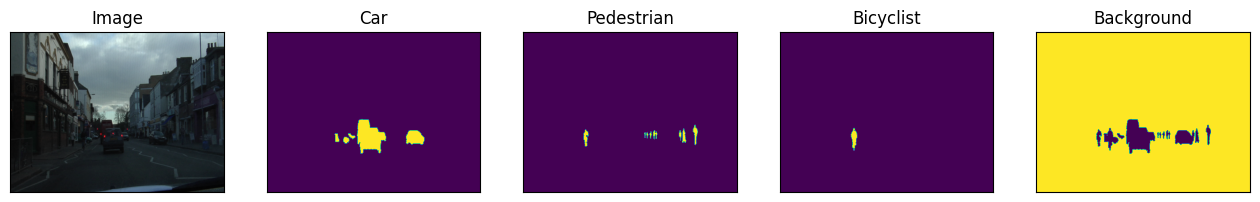

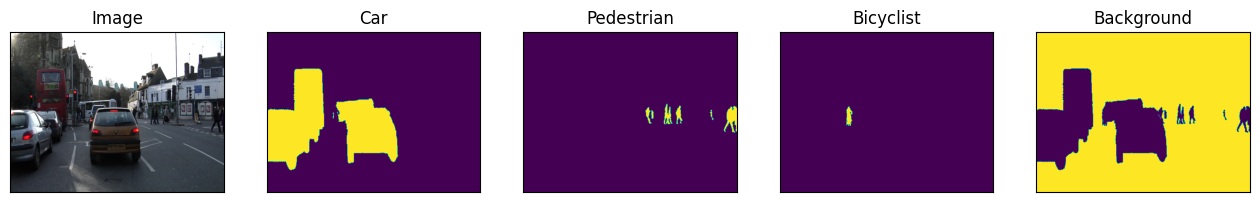

In [10]:
# Example of one image and its classes masks
CLASSES = ['car', 'pedestrian', 'bicyclist']

# dataset = CamVidDataset('camvid', x_train_dir, y_train_dir, classes=CLASSES)
dataset = CamVidDataset('camvid', x_train_dir, y_train_dir, classes=CLASSES)


image, mask = dataset[279]
visualize(
    image=image,
    car=mask[...,0],
    pedestrian=mask[...,1],
    bicyclist=mask[...,2],
    background=mask[...,3],
)

image, mask = dataset[250]
visualize(
    image=image,
    car=mask[...,0],
    pedestrian=mask[...,1],
    bicyclist=mask[...,2],
    background=mask[...,3],
)

### Image augmentation

In [116]:
import albumentations as albu

In [117]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),           # apply preprocessing to image
        albu.Lambda(image=to_tensor, mask=to_tensor),  # convert to tensors
    ]
    return albu.Compose(_transform)                    # container for multiple transformations to be applied sequentially

### Model architecture and loss, metrics, optimizer

In [207]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils

ENCODER = 'timm-res2net50_26w_8s'                      # pretrained CNN
ENCODER_WEIGHTS = 'imagenet'               # pretrained weights on specific dataset
CLASSES = ['car', 'building', 'tree']     # classes for multiclass-single label segmentation

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
ACTIVATION = 'sigmoid' if n_classes == 1 else 'softmax2d'

BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 20
DEVICE = 'cuda'


# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=n_classes,
    activation=ACTIVATION,
)

# loss = smp.utils.losses.DiceLoss()
loss = smp.utils.losses.JaccardLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.65),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Precision(),
    smp.utils.metrics.Accuracy(),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=LR),
])


preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
train_dataset = CamVidDataset(
    # 'camvid',
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), classes=CLASSES,
)

valid_dataset = CamVidDataset(
    # 'camvid',
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), classes=CLASSES,
)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

# FOR OI
# train_dataset = CamVidDataset(
#     'openimages', fiftyone_dataset=oi_dataset,
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
# )

# valid_dataset = CamVidDataset(
#     'openimages', fiftyone_dataset=oi_dataset,
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
# )

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 

### Train the model

In [211]:
train_epoch = smp.utils.train.TrainEpoch(model, loss=loss, metrics=metrics, optimizer=optimizer, device=DEVICE, verbose=True)
valid_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=DEVICE, verbose=True)

# train on CamVid data and save the best based on validation IoU score
max_score = 0
for i in range(0, EPOCHS):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Currently best model')


Epoch: 0
train:   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


valid:   0%|          | 0/101 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


valid: 100%|██████████| 101/101 [00:06<00:00, 15.99it/s, jaccard_loss - 0.1655, iou_score - 0.836, fscore - 0.9104, recall - 0.91, precision - 0.9107, accuracy - 0.9552]
Currently best model

Epoch: 1
valid: 100%|██████████| 101/101 [00:07<00:00, 13.93it/s, jaccard_loss - 0.1674, iou_score - 0.8346, fscore - 0.9093, recall - 0.909, precision - 0.9096, accuracy - 0.9547]

Epoch: 2
valid: 100%|██████████| 101/101 [00:06<00:00, 15.21it/s, jaccard_loss - 0.1736, iou_score - 0.8279, fscore - 0.9057, recall - 0.9055, precision - 0.906, accuracy - 0.9529]

Epoch: 3
valid: 100%|██████████| 101/101 [00:07<00:00, 13.17it/s, jaccard_loss - 0.1545, iou_score - 0.8461, fscore - 0.916, recall - 0.916, precision - 0.9161, accuracy - 0.958]
Currently best model

Epoch: 4
valid: 100%|██████████| 101/101 [00:06<00:00, 16.01it/s, jaccard_loss - 0.1416, iou_score - 0.8599, fscore - 0.9244, recall - 0.9242, precision - 0.9245, accuracy - 0.9622]
Currently best model

Epoch: 5
valid: 100%|██████████| 101/10

### Test best model

In [16]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

# create test dataset
test_dataset = CamVidDataset(
    # 'camvid',
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# evaluate model on test CamVid set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

test_logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:14<00:00, 15.73it/s, jaccard_loss - 0.2079, iou_score - 0.793, fscore - 0.8838, recall - 0.8832, precision - 0.8844, accuracy - 0.9419]


In [17]:
# best_model.eval()

# for image in test_dataloader:
#   # print(image[0].squeeze().shape)
#   outputs = best_model(image[0].to(DEVICE))
#   predictions = (outputs>0.5).float()

In [18]:
# # print(np.transpose(predictions.squeeze().cpu().numpy(), (1, 2, 0)))
# # print(np.transpose(image[0].squeeze().cpu().numpy(), (1, 2, 0)))
# plt.imshow((np.transpose(predictions.squeeze().cpu().numpy(), (1, 2, 0)))[:,:,2])
# plt.show()
# plt.imshow(np.transpose(image[1].squeeze().cpu().numpy(), (1, 2, 0)))

In [19]:
# test dataset without transformations for image visualization
test_dataset_vis = CamVidDataset(x_test_dir, y_test_dir, classes=CLASSES)
CLASSES.append("background")

['car', 'building', 'tree', 'background']


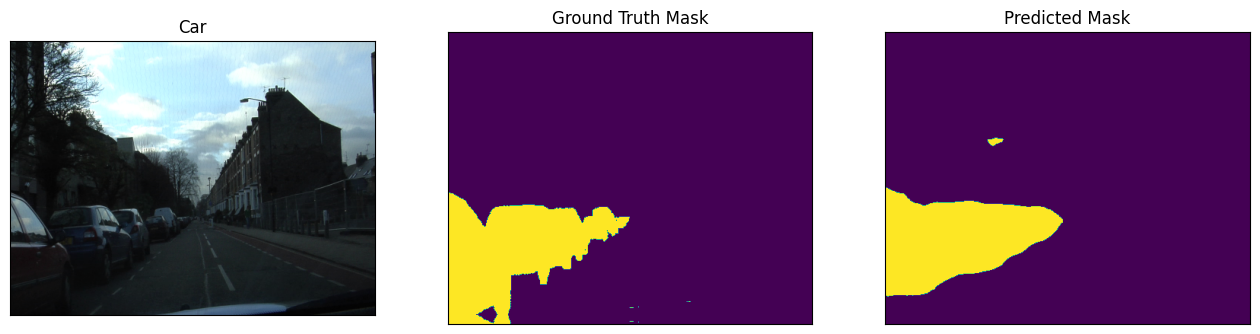

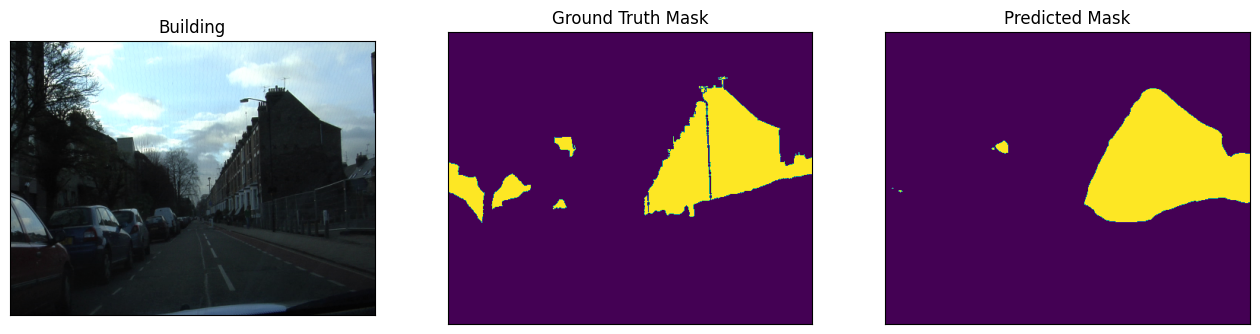

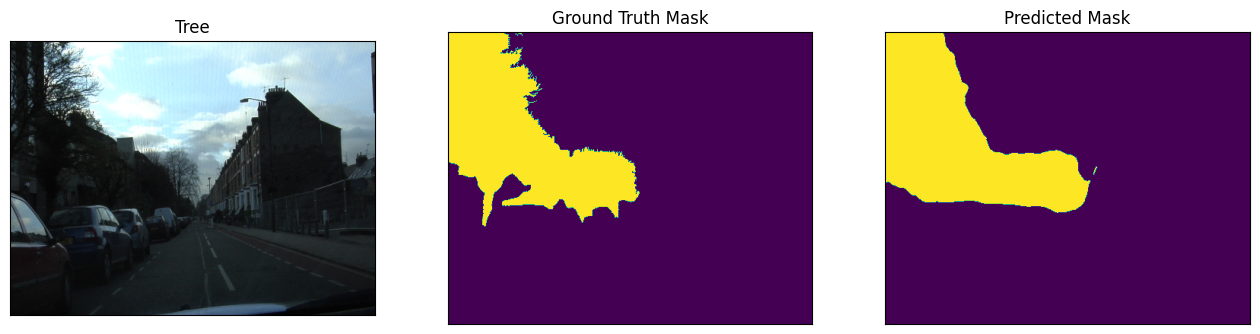

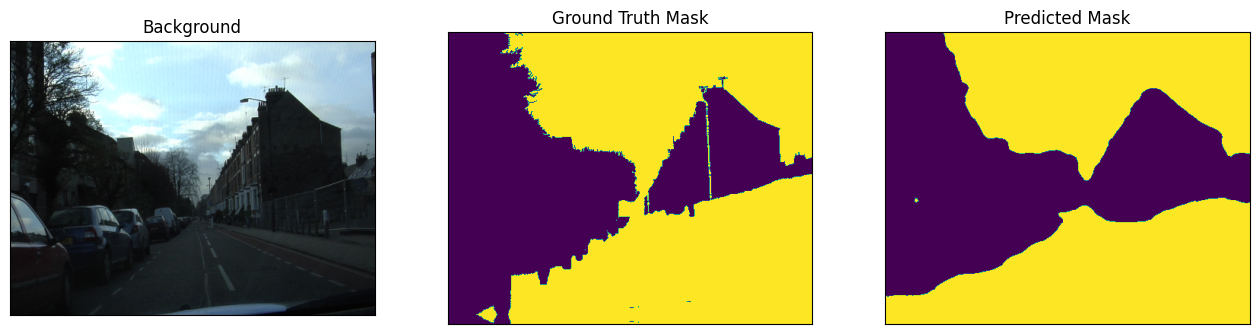

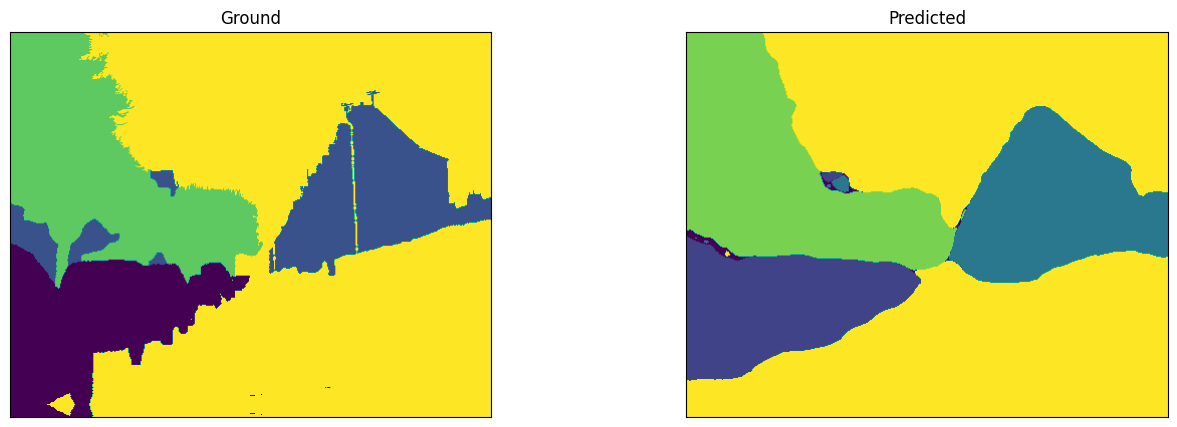

In [22]:
# from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
# n = np.random.choice(len(test_dataset))
# n = 15

image_vis = test_dataset_vis[n][0].astype('uint8')
image, gt_mask = test_dataset[n]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

print(CLASSES)
for indx, cl in enumerate(CLASSES):
  args = {
        cl: image_vis,
        'ground_truth_mask': gt_mask[indx],
        'predicted_mask': pr_mask[indx]
        }
  visualize(**args)


# print(f1_score(gt_mask.flatten(), pr_mask.flatten()))
# print(accuracy_score(gt_mask.flatten(), pr_mask.flatten()))
# print(precision_score(gt_mask.flatten(), pr_mask.flatten()))
# print(recall_score(gt_mask.flatten(), pr_mask.flatten()))

# plt.imshow(test_dataset_vis[n][0])
# plt.imshow(test_dataset_vis[n][1])
# plt.imshow(50 * pr_mask[0] + 100*pr_mask[1] + 200*pr_mask[2])

visualize(
    ground = 50 * gt_mask[0] + 100*gt_mask[1] + 200*gt_mask[2] + 250*gt_mask[3],
    predicted = 50 * pr_mask[0] + 100*pr_mask[1] + 200*pr_mask[2] + 250*pr_mask[3]
    )
# plt.show()

## Testing on OpenImages

In [20]:
pip install fiftyone

In [ ]:
# !pip install opencv-python-headless==4.5.4.60 fiftyone

### Download images of classes

In [212]:
import fiftyone

# Available classes matching CamVid:
# Car, Christmas tree, Building, Ambulance, Stop sign, Person, Traffic sign,
classes_oi = ["Car", "Christmas tree", "Ambulance"]
classes_count = 3+1     # +1 for background

oi_dataset = fiftyone.zoo.load_zoo_dataset(
              "open-images-v6",
              split="train",
              label_types=["segmentations"],
              classes=classes_oi,
              max_samples=100)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/root/fiftyone/open-images-v6/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [2.7s elapsed, 0s remaining, 1.8Gb/s]        


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [2.7s elapsed, 0s remaining, 1.8Gb/s]        


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v6/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v6/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmp5k44bqop/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v6/train/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip' to '/root/fiftyone/open-images-v6/train/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 100 images


 100% |███████████████████| 100/100 [11.0s elapsed, 0s remaining, 8.4 files/s]       


INFO:eta.core.utils: 100% |███████████████████| 100/100 [11.0s elapsed, 0s remaining, 8.4 files/s]       


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 100/100 [10.3s elapsed, 0s remaining, 12.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [10.3s elapsed, 0s remaining, 12.9 samples/s]      


Dataset 'open-images-v6-train-100' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-train-100' created


In [ ]:
# fiftyone.utils.openimages.get_segmentation_classes()

### Custom Dataset class for OI

In [266]:
import torchvision.transforms.functional as transform

class OpenImagesDataset(torch.utils.data.Dataset):
  def __init__(self, dataset):
    # TODO: More transforms and image augmentation
    self.transforms = transforms.Compose([
        transforms.Resize((384, 480))
        ])

    self.fifty_one_dataset = dataset

  def __len__(self):
    return self.fifty_one_dataset.count()

  def __getitem__(self, idx):
    item = self.fifty_one_dataset[idx:idx+1].first()

    # get image
    # Reads a file using pillow
    image = cv2.imread(item.filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # The image can be converted to tensor using
    tensor_image = transform.to_tensor(image)
    image_tensor = tensor_image

    # get masks
    masks_tensor = torch.zeros(classes_count, image_tensor.shape[1], image_tensor.shape[2])
    for detection in item.ground_truth.detections:
      index = classes_oi.index(detection.label) + 1 if detection.label in classes_oi else None

      if index is None:
        continue

      segmentation = detection.to_segmentation(frame_size=(image_tensor.shape[2], image_tensor.shape[1]))

      masks_tensor[index, :, :] += segmentation.mask / 255.0

    # add background class
    background_mask = (masks_tensor.sum(dim=0).clamp(min=0, max=1) - 1) * (-1)
    masks_tensor[0, :, :] = background_mask
    masks_tensor = masks_tensor.clamp(min=0, max=1)

    image_tensor = self.transforms(image_tensor)
    masks_tensor = self.transforms(masks_tensor)

    # masks_tensor = torch.argmax(masks_tensor, dim=0)

    return image_tensor, masks_tensor

### Evaluate model on OI set


In [ ]:
# classes_oi.append("background")

In [267]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

oi_dataset_class = OpenImagesDataset(dataset=oi_dataset)
oi_dataset_dataloader = DataLoader(oi_dataset_class, batch_size = 1)
logs = test_epoch.run(oi_dataset_dataloader)

# 22 46 69
# print(oi_dataset_class[22][1].shape)      #mask
# print(oi_dataset_class[22][0][0].shape)   #orig
# plt.imshow(oi_dataset_class[22][0][0])

valid: 100%|██████████| 100/100 [00:11<00:00,  8.46it/s, jaccard_loss - 0.9531, iou_score - 0.04413, fscore - 0.08441, recall - 0.08422, precision - 0.08461, accuracy - 0.5311]


### Plot openimages test

42


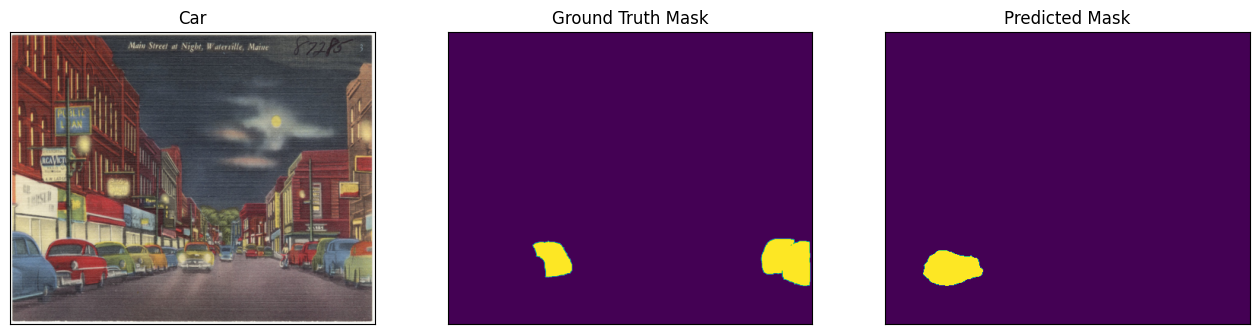

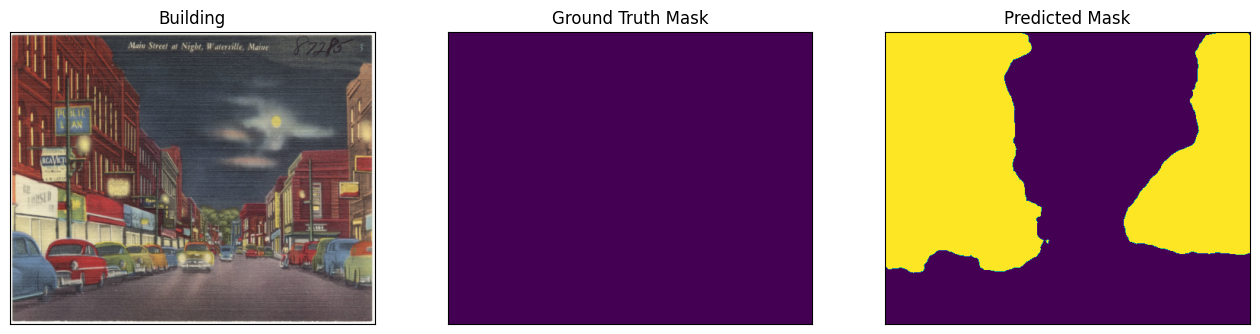

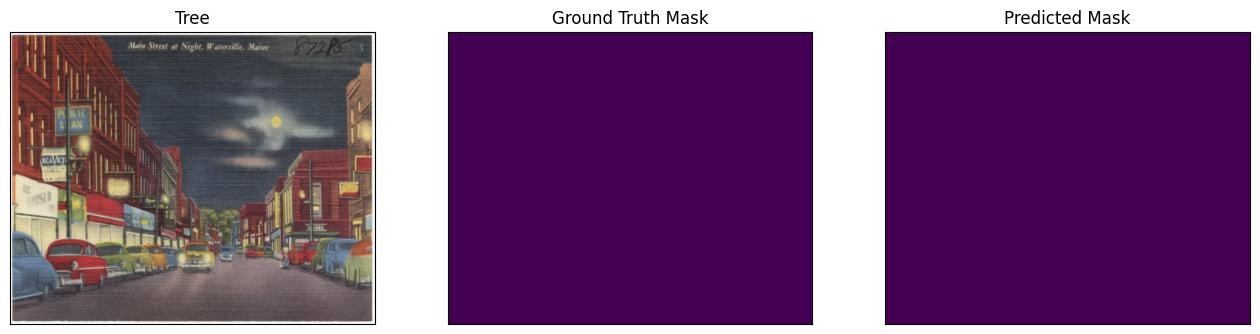

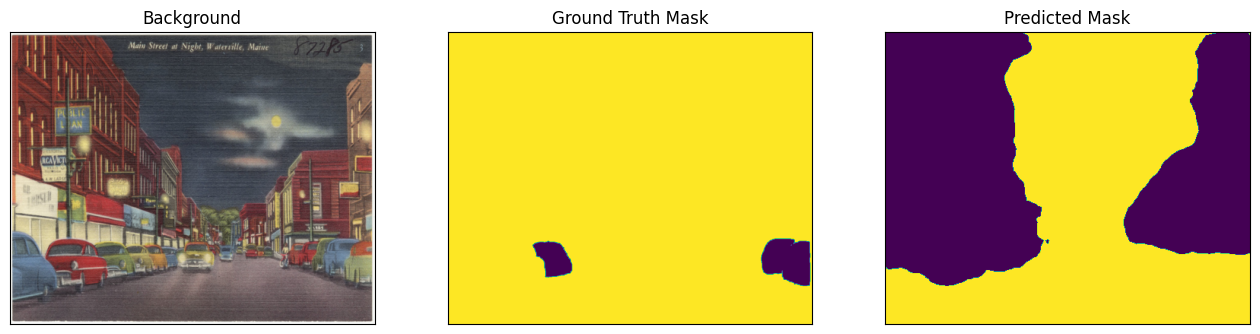

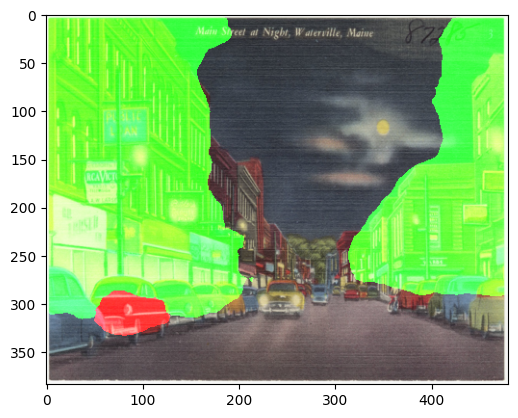

In [270]:

n = np.random.choice(len(oi_dataset_class))
print(n)
# n = 74
# n = 9
# n = 16
# n = 60
# n = 30

image_vis = oi_dataset_class[n][0].permute((1, 2, 0))
image, gt_mask = oi_dataset_class[n]

x_tensor = image.to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

for indx, cl in enumerate(CLASSES[0:3]):
  args = {
        cl: image_vis,
        'ground_truth_mask': gt_mask[indx+1],
        'predicted_mask': pr_mask[indx]
        }
  visualize(**args)

visualize(
    background= image_vis,
    ground_truth_mask= gt_mask[0],
    predicted_mask= pr_mask[3])

# plt.imshow(image_vis[:,:] + 50 * pr_mask[0] + 100*pr_mask[1] + 200*pr_mask[2])
mask_add = np.stack([50 * pr_mask[0], 100*pr_mask[1], 200*pr_mask[2]], axis=-1).astype('float')    # stacks all masks into single multi-channel array
plt.imshow(image_vis[:,:] + mask_add)


## random image



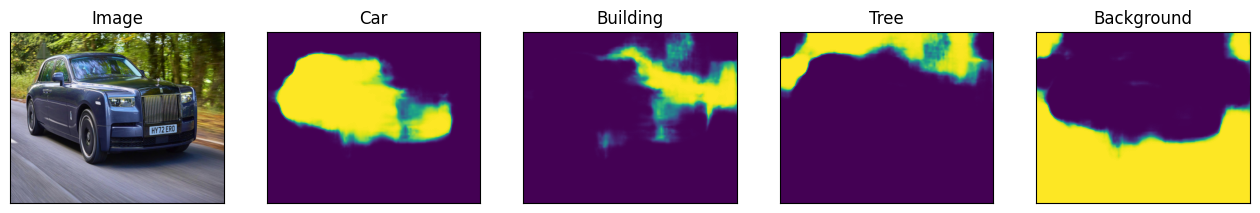

In [301]:
import requests
from google.colab import files as FILE

transform_resize = transforms.Compose([
        transforms.Resize((384, 480)),
])


URL = "https://www.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/images/car-reviews/first-drives/legacy/rolls_royce_phantom_top_10.jpg?itok=XjL9f1tx"
img_data = requests.get(URL).content
with open('random_sample.jpg', 'wb') as handler:
    handler.write(img_data)

sample = "/content/random_sample.jpg"
image = cv2.imread(sample)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = transform.to_tensor(image)
image_tensor = transform_resize(image)

# plt.imshow(image.permute((1,2,0)))

best_model.eval()
with torch.no_grad():
  prediction = best_model(image_tensor.to(DEVICE).unsqueeze(0))
  prediction = prediction.squeeze().cpu()

visualize(
    image = transform_resize(image).permute((1,2,0)),
    car = prediction[0],
    building = prediction[1],
    tree = prediction[2],
    background = prediction[3],
)




---



---



---



## DRAFT

In [ ]:
# session = fiftyone.launch_app(oi_dataset)

In [ ]:
# image = cv2.imread("")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# mask = cv2.imread("", 0)

# class_values = [CLASSES.index(cls.lower()) for cls in ["car", "pedestrian"]]

# # extract certain classes from mask (e.g. cars)
# masks = [(mask == v) for v in class_values]
# print(masks)

# mask = np.stack(masks, axis=-1).astype('float')
# print(mask.shape)
# print(plt.imshow(mask[:,:,0]))

In [ ]:
# # image_pvz = openimages_dataset[2][0]
# # mask_pvz = openimages_dataset[2][1]

# image_pvz = dataset[2][0]
# # mask_pvz = dataset[2][1]

# print(type(image_pvz))

# # x_tensor = image_pvz.to_tensor().to(DEVICE).unsqueeze(0)
# # mask_pred = best_model.predict(x_tensor)
# # predicted_masks = (mask_pred.squeeze().cpu().numpy().round())


In [ ]:
# img_show = np.clip(np.transpose(image_pvz.numpy(), (1, 2, 0)), 0, 1)
# plt.imshow(img_show)
# # plt.imshow(predicted_masks[0])
# # plt.show()

In [ ]:
# pip install openimages scikit-image

In [ ]:
# from openimages.download import download_dataset
# download_dataset("/OpenImages", class_labels=classes_oi, annotation_format="pascal", limit=100)

In [ ]:
# ids_images = os.listdir("/OpenImages/car/images")
# ids_masks = os.listdir("/OpenImages/car/pascal")

# images_fps = [os.path.join("/OpenImages/car/images", image_id) for image_id in ids_images]
# masks_fps = [os.path.join("/OpenImages/car/pascal", image_id) for image_id in ids_masks]

# print(images_fps[99])
# print(masks_fps[99])
# image = cv2.imread(images_fps[99])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)